In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,fbeta_score
import mlflow
import mlflow.sklearn

mlflow.set_experiment("projet 6")


<Experiment: artifact_location='file:c:/Users/User/Desktop/Formation IA/Projet6/mlruns/4', creation_time=1766133397243, experiment_id='4', last_update_time=1766133397243, lifecycle_stage='active', name='projet 6', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [5]:
with mlflow.start_run(run_name="test_mlflow"):
    mlflow.log_param("test_param", 1)
    mlflow.log_metric("test_metric", 0.123)


In [6]:
df = pd.read_csv("Data/Processed/application_train_fused.csv")


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["TARGET"])
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((246008, 139), (61503, 139))

Définition du coût métier

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np

# coût métier
COST_FN = 10
COST_FP = 1

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return COST_FN * fn + COST_FP * fp

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

models = {
    # "LogisticRegression": LogisticRegression(
    #     class_weight="balanced", max_iter=1000, random_state=42
    # ),
    # "RandomForest": RandomForestClassifier(
    #     n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1
    # ),
    # "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(
        class_weight="balanced",
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ),
     "MLP_ReLU": MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="relu",
        max_iter=300,
        random_state=42
    ),
    "MLP_Sigmoid": MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="logistic",
        max_iter=300,
        random_state=42
    )
}

auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ]
)


In [16]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name): 
         
        mlflow.set_tag("step", "etape_3_modelisation")
        mlflow.set_tag("imbalance_handling", "class_weight_balanced")
        mlflow.set_tag("metrics_phase", "model_selection")


        pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

        auc_scores = cross_val_score(
            pipeline,
            X,        
            y,
            cv=cv,
            scoring=auc_scorer,
            n_jobs=1  
        )
        
        y_proba = cross_val_predict(
            pipeline,
            X,
            y,
            cv=cv,
            method="predict_proba",
            n_jobs=1
        )[:, 1]

        y_pred = (y_proba >= 0.5).astype(int)

        cost = business_cost(y, y_pred)


        accuracy = accuracy_score(y, y_pred)
        fbeta = fbeta_score(y, y_pred, beta=2)

        mlflow.log_param("model", model_name)
        mlflow.log_metric("auc_cv_mean", auc_scores.mean())
        mlflow.log_metric("accuracy_cv", accuracy)
        mlflow.log_metric("fbeta_cv", fbeta)
        mlflow.log_metric("business_cost_cv", cost)




In [11]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", models["LightGBM"])
])

y_proba = cross_val_predict(
    pipeline,
    X,
    y,
    cv=cv,
    method="predict_proba"
)[:, 1]

y_pred = (y_proba >= 0.5).astype(int)

cost = business_cost(y, y_pred)
print("Coût métier (seuil 0.5) :", cost)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15573
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15658
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15570
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Coût métier (seuil 0.5) : 156509


À seuil de décision fixé à 0.5, le modèle LightGBM génère un coût métier total de 157 562.

## Calcul du seuil de décision optimal (coût métier)


In [12]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

# Pipeline avec le modèle final choisi (LightGBM)
pipeline_lgbm = Pipeline([
    ("preprocess", preprocessor),
    ("model", models["LightGBM"])   ])

# Probabilités en CV 
y_proba = cross_val_predict(
    pipeline_lgbm,
    X,
    y,
    cv=cv,
    method="predict_proba",
    n_jobs=1
)[:, 1]

# Balayage des seuils et calcul du coût métier
thresholds = np.linspace(0.05, 0.95, 19)  
costs = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    costs.append(business_cost(y, y_pred_t))

best_idx = int(np.argmin(costs))
best_threshold = float(thresholds[best_idx])
best_cost = int(costs[best_idx])

print("Seuil optimal =", best_threshold)
print("Coût métier minimal =", best_cost)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15573
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15658
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15570
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Seuil optimal = 0.49999999999999994
Coût métier minimal = 156509


In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Modèle de base
lgbm = LGBMClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

# Pipeline
pipeline_lgbm = Pipeline([
    ("preprocess", preprocessor),
    ("model", lgbm)
])

param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [-1, 10],
    "model__learning_rate": [0.05, 0.1],
}


In [23]:
from sklearn.model_selection import StratifiedKFold

cv_gs = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_gs,
    n_jobs=1,
    verbose=2
)

grid_search.fit(X, y)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15571
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


KeyboardInterrupt: 

In [39]:
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure AUC CV :", grid_search.best_score_)


Meilleurs hyperparamètres : {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300}
Meilleure AUC CV : 0.7726126892613179


In [13]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

best_lgbm = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", best_lgbm)
])


In [14]:
from sklearn.model_selection import cross_val_predict
import numpy as np

y_proba = cross_val_predict(
    final_pipeline,
    X,
    y,
    cv=cv,
    method="predict_proba",
    n_jobs=1
)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)
costs = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    costs.append(business_cost(y, y_pred_t))

best_idx = int(np.argmin(costs))
best_threshold = float(thresholds[best_idx])
best_cost = int(costs[best_idx])

print("Seuil optimal (modèle optimisé) :", best_threshold)
print("Coût métier minimal :", best_cost)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15573
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15658
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15570
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15559
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 253
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Seuil optimal (modèle optimisé) : 0.49999999999999994
Coût métier minimal : 156385


In [15]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("credit_scoring")

with mlflow.start_run(run_name="LightGBM_final"):
    # Log des paramètres clés
    mlflow.log_param("model", "LightGBM")
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("decision_threshold", best_threshold)

    # Log des métriques finales
    mlflow.log_metric("business_cost_final", best_cost)

    # Log du modèle (pipeline complet)
    mlflow.sklearn.log_model(
        sk_model=final_pipeline,
        artifact_path="model",
        registered_model_name="CreditScoring_LightGBM"
    )


2026/01/01 22:12:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'CreditScoring_LightGBM' already exists. Creating a new version of this model...
Created version '3' of model 'CreditScoring_LightGBM'.


In [16]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Récupérer la dernière version du modèle enregistré
model_name = "CreditScoring_LightGBM"
latest_versions = client.get_latest_versions(model_name, stages=["None"])
model_version = latest_versions[0].version


C:\Users\User\AppData\Local\Temp\ipykernel_11168\2984441371.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(model_name, stages=["None"])


In [17]:
final_pipeline.fit(X, y)


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15668
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

c:\Users\User\Desktop\Formation IA\Projet6\projet6\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


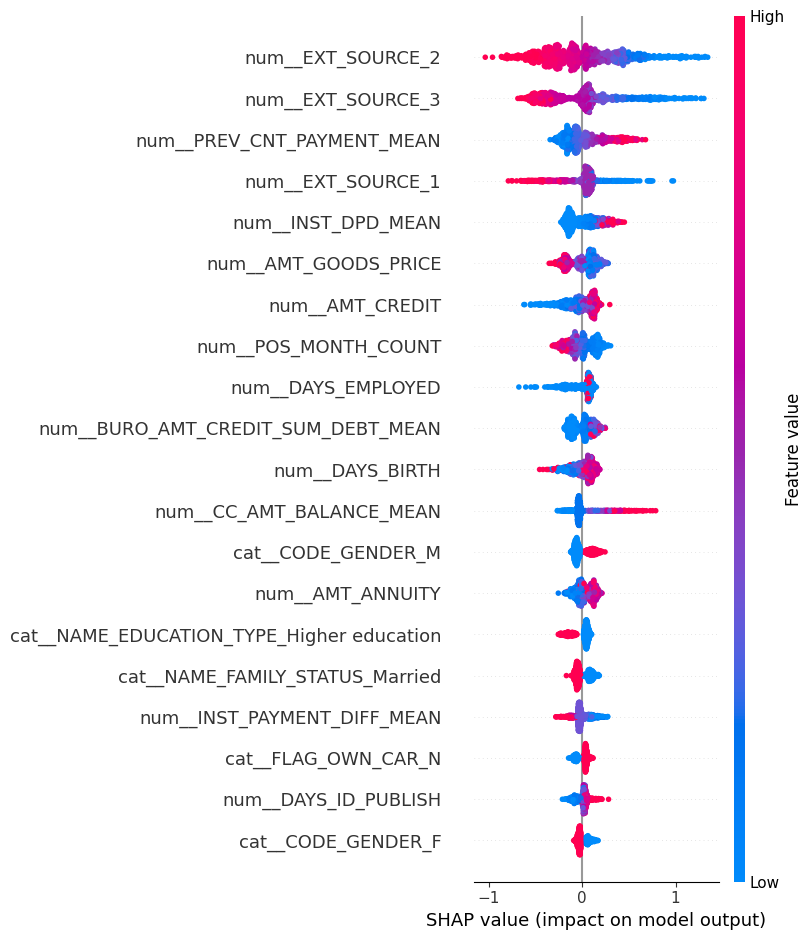

In [ ]:
import numpy as np
import pandas as pd
import shap


preprocess = final_pipeline.named_steps["preprocess"]
model = final_pipeline.named_steps["model"]

# Transofrmation des données
X_transformed = preprocess.transform(X)

# Récupérer les noms de features après preprocessing
feature_names = preprocess.get_feature_names_out()

# Recréer un DataFrame avec les bons noms
X_transformed_df = pd.DataFrame(
    X_transformed,
    columns=feature_names
)

# Echantillons pour SHap
idx = np.random.choice(X_transformed_df.shape[0], 1000, replace=False)
X_shap = X_transformed_df.iloc[idx]

# SHAP GLOBAL
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(
    X_shap,
    check_additivity=False
)

shap.summary_plot(shap_values, X_shap)




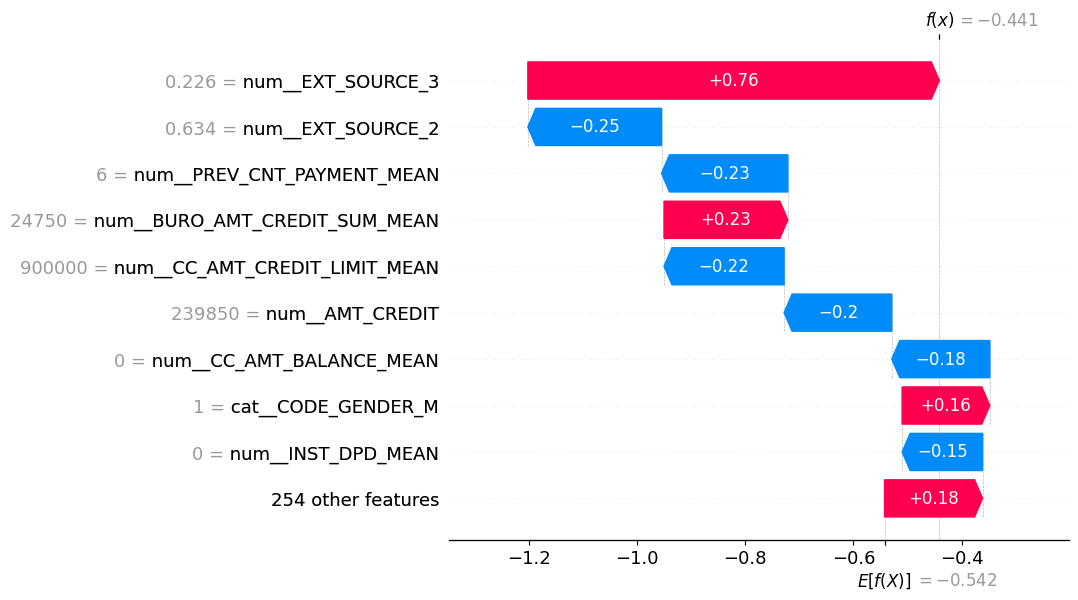

In [ ]:
i = 0

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_shap.iloc[i],
        feature_names=X_shap.columns
    )
)